# REQUIREMENTS

In [1]:
import wrds, datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

conn = wrds.Connection()

# veervohra
# rzoj3miTfgD$

Loading library list...
Done


# DATA COLLECTION

In [2]:
sp500_data = conn.raw_sql("""
SELECT
    caldt AS date,
    sprtrn AS daily_return -- Equal-Weighted Return (includes distributions) (ewretd)
FROM
    crspq.dsp500
WHERE
    caldt >= '1990-01-01'
ORDER BY
    caldt;
""")
sp500_data['date'] = pd.to_datetime(sp500_data['date'])

In [3]:
risk_free_data = conn.raw_sql('''
    SELECT
        date,
        rf AS daily_rf_rate -- One Month Treasury Bill Rate (daily)
    FROM
        ff.factors_daily
    WHERE
        date >= '1990-01-01'
''')
risk_free_data['date'] = pd.to_datetime(risk_free_data['date'])

### COMPANY DATA

In [4]:
# retrieves ID (permno) and earliest recorded name for each company in CRSP database
# 37,776 companies available
comps = conn.raw_sql( '''
SELECT permno, MIN(comnam) AS company_name
FROM crsp.stocknames
GROUP BY permno
''')

comps[comps['company_name'] == 'NVIDIA CORP']

,permno,company_name
8,86580,NVIDIA CORP


In [5]:
# Using NVIDIA as example to figure out the algorithm.

conn.raw_sql('''
SELECT *
FROM crsp.ccmxpf_linktable
WHERE lpermno = 86580;
''')

,gvkey,linkprim,liid,linktype,lpermno,lpermco,usedflag,linkdt,linkenddt
0,117768,P,01,LU,86580.0,16382.0,1.0,1999-01-22,None


In [6]:
nvidia = conn.raw_sql('''
WITH comp_data AS (
    SELECT
        f.gvkey,
        f.datadate AS date,
        f.atq AS total_assets,  -- Total Assets
        f.chq AS cash_holdings,  -- Cash and Short-Term Investments
        f.rdq AS reporting_date -- Date of which information was reported
    FROM
        comp.fundq f
    WHERE
        gvkey = '117768'
        AND f.datadate >= '1990-01-01'  -- Ensure data is after the link start date
),
crsp_data AS (
    SELECT
        permno,
        date,
        ret AS stock_return,  -- Stock returns from CRSP
        prc AS stock_price,
        prc * shrout AS market_cap  -- Market cap
    FROM
        crsp.msf
    WHERE
        permno = 86580  -- Use the correct permno for gvkey 003243
)
SELECT
    c.gvkey,
    cr.permno,
    c.date, -- Date of each quarter (this is when the information was real)
    c.reporting_date, -- Reporting date (this is when information became known to us)
    cr.stock_price,
    c.cash_holdings,
    c.total_assets
FROM
    comp_data c
JOIN
    crsp_data cr ON c.date = cr.date
ORDER BY
    c.gvkey, c.date;

''')

nvidia['date'] = pd.to_datetime(nvidia['date'])
nvidia['quarter_start'] = nvidia['date'] - pd.offsets.QuarterBegin(n=2)
nvidia['quarter_end'] = nvidia['date']


In [7]:
def aggregate_quarterly(start_date, end_date, daily_data, column, agg_func):
    """
    Aggregates data within the given start_date and end_date range.
    """
    mask = (daily_data['date'] >= start_date) & (daily_data['date'] <= end_date)
    return agg_func(daily_data.loc[mask, column])

nvidia['snp_quarterly_return'] = nvidia.apply(
    lambda row: aggregate_quarterly(row['quarter_start'], row['quarter_end'], sp500_data, 'daily_return', 
                                    lambda x: np.prod(1 + x) - 1), axis=1
)

nvidia['rf_quarterly_rate'] = nvidia.apply(
    lambda row: aggregate_quarterly(row['quarter_start'], row['quarter_end'], risk_free_data, 'daily_rf_rate', 
                                    np.mean), axis=1
)

# CALCULATIONS (CASH-HEDGING & RETURNS)

In [ ]:
nvidia['cash_share_weight'] = (nvidia['cash_holdings'] / nvidia['total_assets'])
nvidia['quarterly_return'] = nvidia['stock_price'].pct_change(fill_method=None)

### $ b_{t}^{i} $ - return on cash between periods

In [10]:
# the paper calculates it in a pretty complicated method, we'll start like this

nvidia['cash_holdings_t_minus_1'] = nvidia['cash_holdings'].shift()
nvidia['b_it'] = ( nvidia['cash_holdings'] - nvidia['cash_holdings_t_minus_1'] ) / nvidia['cash_holdings_t_minus_1']

### $ e_{t}^{i} $ - cash hedged returns

In [ ]:
# calculate the cash-hedged return (e_it)

nvidia['cash_hedged_return'] = (1 / (1 - nvidia['cash_share_weight'])) * (nvidia['quarterly_return'] - (nvidia['cash_share_weight']  * nvidia['b_it']))

nvidia = nvidia.dropna()

nvidia

,gvkey,permno,date,reporting_date,stock_price,cash_holdings,total_assets,quarter_start,quarter_end,snp_quarterly_return,...,cash_share_weight,quarterly_return,cash_holdings_t_minus_1,b_it,cash_hedged_return,nvidia_beta,google_beta,snp_cum_return,nvidia_cum_return,google_cum_return
27,117768,86580,2008-04-30,2008-05-08,20.55000,803.308,3807.458,2007-12-01,2008-04-30,-0.064512,...,0.210983,-0.164294,508.869,0.578615,-0.362948,4.351433,4.700772,-0.062951,0.126027,-0.603172
28,117768,86580,2008-07-31,2008-08-12,11.44000,719.143,3960.049,2008-03-01,2008-07-31,-0.047535,...,0.181600,-0.443309,803.308,-0.104773,-0.518429,0.442636,-0.703418,-0.107494,-0.373151,-0.808899
29,117768,86580,2008-10-31,2008-11-06,8.76000,461.253,3648.898,2008-06-01,2008-10-31,-0.308225,...,0.126409,-0.234266,719.143,-0.358607,-0.216273,-0.329788,-0.720329,-0.382586,-0.520000,-0.850229
30,117768,86580,2009-04-30,2009-05-07,11.48000,512.274,3178.704,2008-12-01,2009-04-30,-0.026145,...,0.161158,0.310502,461.253,0.110614,0.348905,0.697278,0.421414,-0.398728,-0.370959,-0.797973
31,117768,86580,2009-07-31,2009-08-06,12.93000,523.785,3298.409,2009-03-01,2009-07-31,0.343343,...,0.158799,0.126307,512.274,0.022470,0.145909,0.585759,0.603210,-0.192286,-0.291507,-0.768496
32,117768,86580,2010-04-30,2010-05-13,15.71000,447.262,3803.030,2009-12-01,2010-04-30,0.083111,...,0.117607,0.215004,523.785,-0.146096,0.263132,0.529918,0.535976,-0.125156,-0.139178,-0.707580
33,117768,86580,2011-01-31,2011-02-16,23.92000,665.361,4495.246,2010-09-01,2011-01-31,0.225663,...,0.148014,0.522597,447.262,0.487631,0.528672,-0.162400,-0.244792,0.072264,0.310685,-0.552985
34,117768,86580,2011-10-31,2011-11-10,14.80000,566.816,5089.043,2011-06-01,2011-10-31,-0.068317,...,0.111380,-0.381271,665.361,-0.148108,-0.410496,1.416021,1.495778,-0.000990,-0.189041,-0.736483
35,117768,86580,2012-01-31,2012-02-15,14.77000,667.876,5552.928,2011-09-01,2012-01-31,0.076728,...,0.120275,-0.002027,566.816,0.178294,-0.026680,3.090084,3.216141,0.075663,-0.190685,-0.743514
36,117768,86580,2012-04-30,2012-05-11,13.00000,369.135,5708.167,2011-12-01,2012-04-30,0.121052,...,0.064668,-0.119838,667.876,-0.447300,-0.097197,2.860522,3.005139,0.205874,-0.287671,-0.768443


# BETA CALCULATION

Seems like in some instances cash_hedged_returns is getting super over inflated. Ideally, that is what we want! But will need to make sure the raise in risk is also reflected.

Next steps:
* Calculate Beta for non-cash assets in NVIDIA
* Use above data to test returns in cash-hedged for NVIDIA over time (long-only) 
* (etc)

Calculating Stock Beta and Cash-Hedged Beta (PiT).

In [28]:
window = 4

# Step 1: Calculate rolling beta for NVIDIA and Google
def calculate_rolling_beta(stock_return, market_return, window):
    rolling_cov = stock_return.rolling(window).cov(market_return)
    rolling_var = market_return.rolling(window).var()
    return rolling_cov / rolling_var

In [29]:

nvidia['nvidia_beta'] = calculate_rolling_beta(nvidia['quarterly_return'], nvidia['snp_quarterly_return'], window)
nvidia['google_beta'] = calculate_rolling_beta(nvidia['cash_hedged_return'], nvidia['snp_quarterly_return'], window)

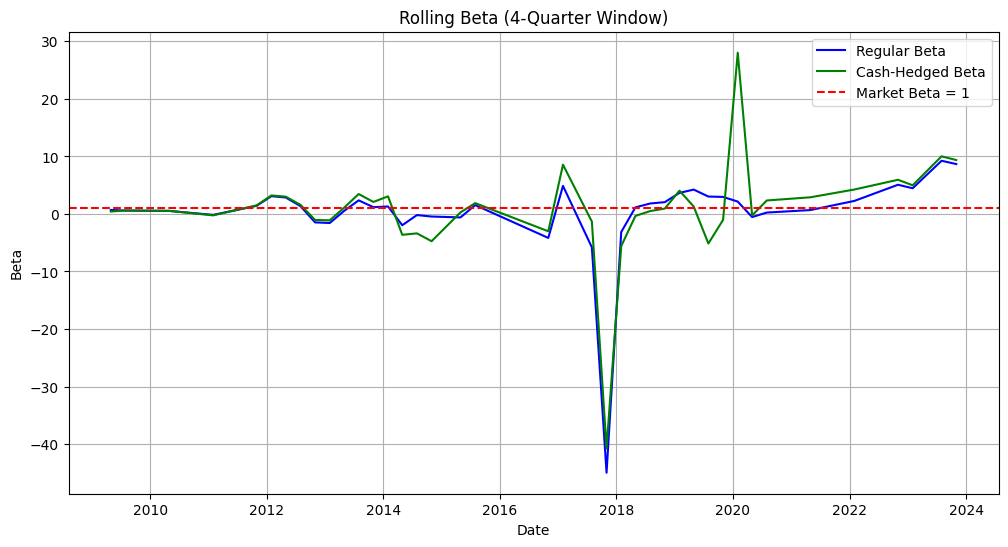

In [30]:
# Step 2: Plot rolling beta
plt.figure(figsize=(12, 6))
plt.plot(nvidia['date'], nvidia['nvidia_beta'], label='Regular Beta', color='blue')
plt.plot(nvidia['date'], nvidia['google_beta'], label='Cash-Hedged Beta', color='green')
plt.axhline(1, color='red', linestyle='--', label='Market Beta = 1')
plt.title('Rolling Beta (4-Quarter Window)')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
plt.grid()
plt.show()


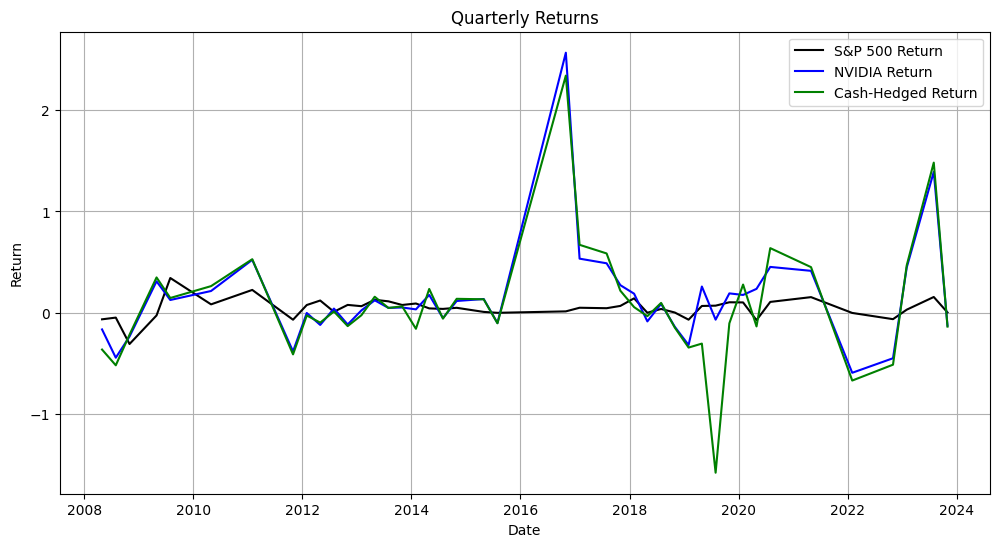

In [31]:

# Step 3: Plot quarterly returns
plt.figure(figsize=(12, 6))
plt.plot(nvidia['date'], nvidia['snp_quarterly_return'], label='S&P 500 Return', color='black')
plt.plot(nvidia['date'], nvidia['quarterly_return'], label='NVIDIA Return', color='blue')
plt.plot(nvidia['date'], nvidia['cash_hedged_return'], label='Cash-Hedged Return', color='green')
plt.title('Quarterly Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid()
plt.show()

In [32]:
# Step 4: Calculate cumulative returns
nvidia['snp_cum_return'] = (1 + nvidia['snp_quarterly_return']).cumprod() - 1
nvidia['nvidia_cum_return'] = (1 + nvidia['quarterly_return']).cumprod() - 1
nvidia['google_cum_return'] = (1 + nvidia['cash_hedged_return']).cumprod() - 1

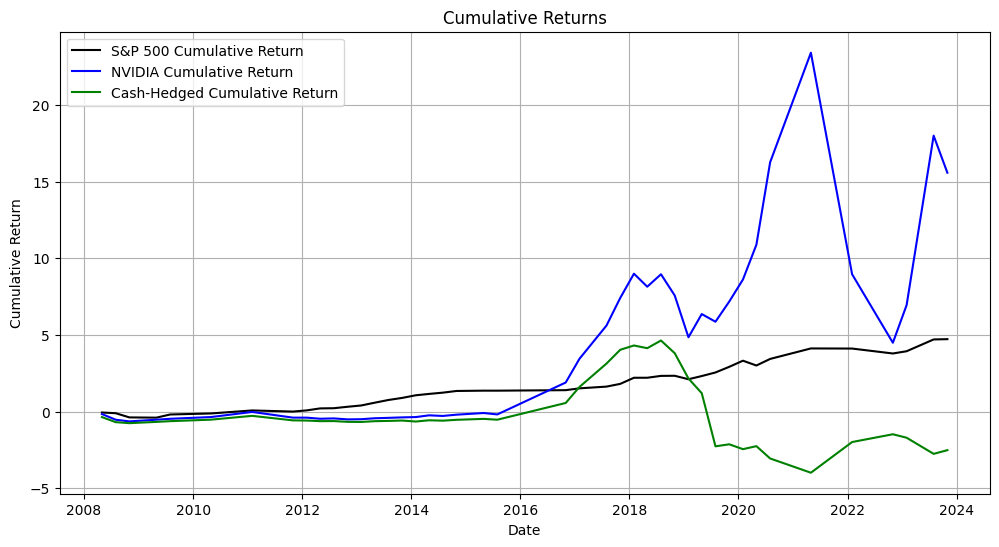

In [33]:
# Step 5: Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(nvidia['date'], nvidia['snp_cum_return'], label='S&P 500 Cumulative Return', color='black')
plt.plot(nvidia['date'], nvidia['nvidia_cum_return'], label='NVIDIA Cumulative Return', color='blue')
plt.plot(nvidia['date'], nvidia['google_cum_return'], label='Cash-Hedged Cumulative Return', color='green')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()